# Rotate vols and FSC

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config


In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import *
from src.datasets import *
from src.residual import get_volume_residual

import jax
import mrcfile
from jax.scipy.special import gammaln

plt.rcParams["figure.figsize"]=6,6

### Load the volumes

In [3]:
#file1 = "/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset10k/vol1_84.mrc"
#file2 = "/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset_results10k/relion_noisy/rec_iter_176.mrc"
#nx0 = 256
#pixel_size = 1.244531


#file1 = "/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset10k/vol2_84.mrc"
#file2 = "/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset_results10k/cryodrgn_noisy/rec_iter_176.mrc"
#nx0 = 320
#pixel_size = 1.31

file1 = "/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem1v/rec_iter_146.mrc"
file2 = "/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem2v/rec_iter_146.mrc"
nx0 = 320
pixel_size = 1.31

vol1 = mrcfile.open(file1).data
vol2 = mrcfile.open(file2).data

vol1_f, _, _ = volume_fourier(vol1, pixel_size)
vol2_f, _, _ = volume_fourier(vol2, pixel_size)

In [4]:
nx = vol2_f.shape[0]
grid = [1, nx]

In [5]:
vol1_f, grid = crop_fourier_volume(vol1_f, grid, nx)

In [6]:
res, fsc, shell_points = calc_fsc(vol1_f, vol2_f, grid)

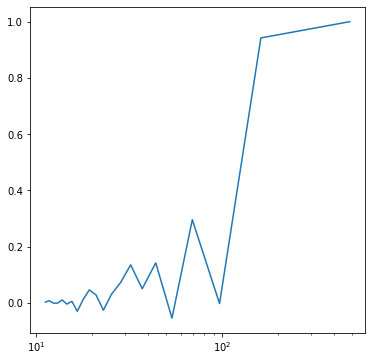

In [7]:
res_angs = nx0 * pixel_size/res
plt.semilogx(res_angs, fsc)

In [8]:
res

DeviceArray([ 0.8660254 ,  2.59807621,  4.33012702,  6.06217783,
              7.79422863,  9.52627944, 11.25833025, 12.99038106,
             14.72243186, 16.45448267, 18.18653348, 19.91858429,
             21.65063509, 23.3826859 , 25.11473671, 26.84678752,
             28.57883832, 30.31088913, 32.04293994, 33.77499075,
             35.50704156, 37.23909236], dtype=float64)

In [9]:
res_angs

DeviceArray([484.05046569, 161.35015523,  96.81009314,  69.15006653,
              53.78338508,  44.00458779,  37.23465121,  32.27003105,
              28.47355681,  25.4763403 ,  23.05002218,  21.04567242,
              19.36201863,  17.92779503,  16.69139537,  15.61453115,
              14.66819593,  13.83001331,  13.08244502,  12.4115504 ,
              11.80610892,  11.25698757], dtype=float64)

In [10]:
@jax.jit
def calc_corr(v1, v2):
    corr = jnp.sum(v1 * jnp.conj(v2)) / (jnp.linalg.norm(v1.ravel(),2) * jnp.linalg.norm(v2.ravel(),2))
    return jnp.real(corr)

@jax.jit
def rotate_and_calc_corr(vol1_f, vol2_f, angles0, angles_i):

    vol1_r = rotate_and_interpolate(vol1_f, angles0, grid, grid)
    vol2_r = rotate_and_interpolate(vol2_f, angles_i, grid, grid)
    return calc_corr(vol1_r, vol2_r)

rotate_and_calc_corr_vmap = jax.jit(jax.vmap(rotate_and_calc_corr, in_axes=(None, None, None, 0)))

def rotate_and_interpolate_full_object(vol, angles, grid):
    proj_coords = rotate_full_grid(grid, angles)
    return interpolate(proj_coords, grid, vol, "tri")

In [11]:
N = 100

a1_range = jnp.linspace(0, 2*jnp.pi, N)
a2_range = jnp.linspace(0, jnp.pi, N)
a3_range = jnp.linspace(0, 2*jnp.pi, N)

A1, A2, A3 = jnp.meshgrid(a1_range, a2_range, a3_range)  

angles = jnp.column_stack([A1.ravel(), A2.ravel(), A3.ravel()])
angles0 = jnp.array([0,0,0])

grid = np.array(grid)
vol1_f = jnp.array(vol1_f)
vol2_f = jnp.array(vol2_f)

In [12]:
#vol2_f = jnp.moveaxis(vol2_f, [0,1,2], [2,1,0]) # Not sure this actually works for reversing chirality

In [13]:
N_batch = 1000
angles_batch = np.array(np.array_split(angles, N_batch))

corrs_batch = []
for bi in np.arange(N_batch):

    corr_i = rotate_and_calc_corr_vmap(vol1_f, vol2_f, angles0, angles_batch[bi])
    corrs_batch.append(corr_i)
    
corrs = np.concatenate(corrs_batch, axis=0)

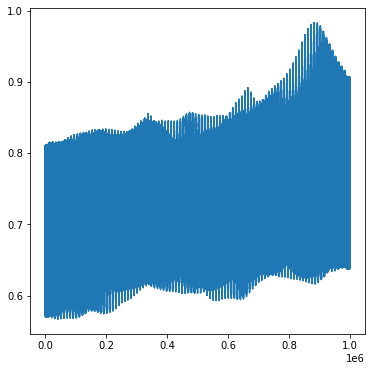

In [14]:
plt.plot(corrs)

In [15]:
print(f"max corr = {jnp.max(corrs)}")
max_idx = jnp.argmax(corrs)
angles_good = angles[max_idx]

vol2_fr = rotate_and_interpolate_full_object(vol2_f, angles_good, grid)
vol2_fr = vol2_fr.reshape([nx,nx,nx])

max corr = 0.9839077609806081


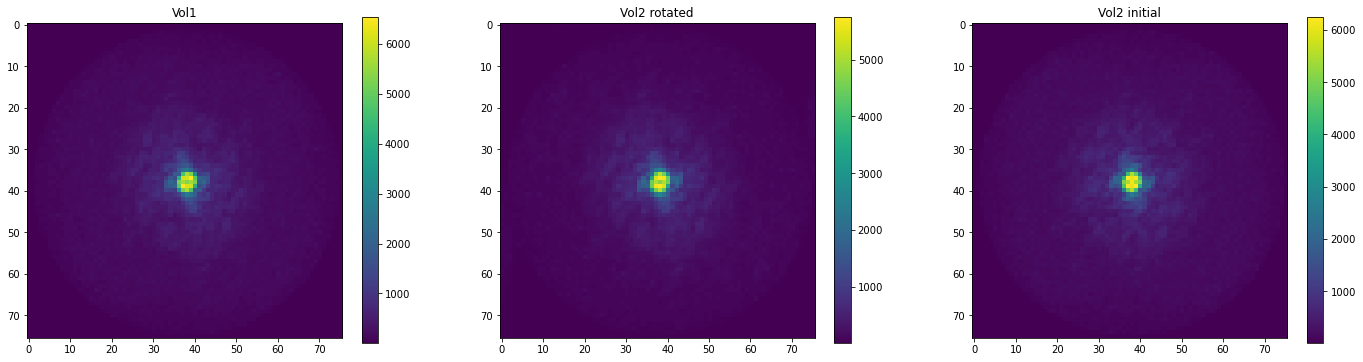

In [16]:
plt.rcParams["figure.figsize"]=24,6

plt.subplot(1,3,1)
mip_x(jnp.abs(jnp.fft.fftshift(vol1_f))); plt.colorbar()
plt.title("Vol1")

plt.subplot(1,3,2)
mip_x(jnp.abs(jnp.fft.fftshift(vol2_fr))); plt.colorbar()
plt.title("Vol2 rotated")


plt.subplot(1,3,3)
mip_x(jnp.abs(jnp.fft.fftshift(vol2_f))); plt.colorbar()
plt.title("Vol2 initial")

plt.rcParams["figure.figsize"]=6,6

In [17]:
res, fsc, shell_points = calc_fsc(vol1_f, vol2_fr, grid)

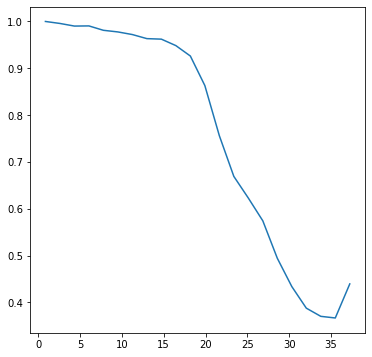

In [18]:
plt.plot(res, fsc)

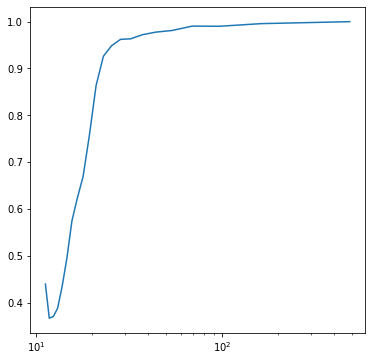

In [19]:
res_angs = nx0 * pixel_size/res
plt.semilogx(res_angs, fsc)

In [20]:
res_angs

DeviceArray([484.05046569, 161.35015523,  96.81009314,  69.15006653,
              53.78338508,  44.00458779,  37.23465121,  32.27003105,
              28.47355681,  25.4763403 ,  23.05002218,  21.04567242,
              19.36201863,  17.92779503,  16.69139537,  15.61453115,
              14.66819593,  13.83001331,  13.08244502,  12.4115504 ,
              11.80610892,  11.25698757], dtype=float64)

In [42]:
fsc

DeviceArray([1.        , 0.99576429, 0.99016562, 0.99050002, 0.98113312,
             0.97763906, 0.97202986, 0.96333671, 0.96222431, 0.94842316,
             0.92617007, 0.86305482, 0.75596958, 0.66899972, 0.6227508 ,
             0.57406399, 0.49411601, 0.43367662, 0.38754078, 0.37004885,
             0.36656269, 0.43934786], dtype=float64)

In [22]:
nx0 * pixel_size/42

9.980952380952383

In [23]:
pixel_size

1.31

In [24]:
nx0

320

### Orientation errors

In [25]:
dataset = "relion_noisy"

In [26]:
data_dir = f"/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset10k/{dataset}/"
star_file = "particles.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = False, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  10000
load_data: data loaded, time:  2.3903141021728516


In [27]:
with open(f"/gpfs/loomis/project/lederman/bt387/simple_cryoem/simulated_dataset_results10k/{dataset}/rec_iter_176_angles", 'rb') as file:
    # Call load method to deserialze
    angles_rec = pickle.load(file)
    
angles_rec = angles_rec[0]

In [28]:
angles0.shape

(10000, 3)

In [29]:
angles_rec.shape

(10000, 3)

In [30]:
theta, cord_distance = err_orientations(angles0, -angles_rec)


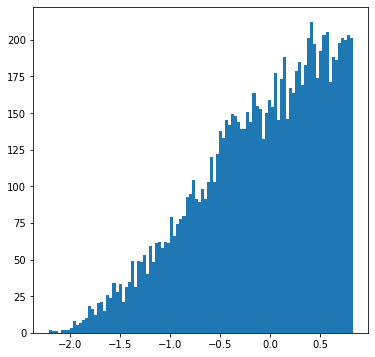

In [31]:
nbins=100
counts, bins = np.histogram(theta - jnp.median(theta), bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

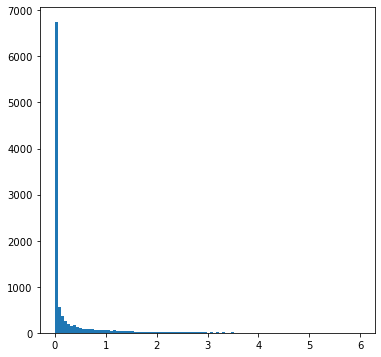

In [32]:
nbins = 100
counts, bins = np.histogram((cord_distance - jnp.median(cord_distance))**2, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [33]:
jnp.max(bins)

DeviceArray(5.9832329, dtype=float64)

In [34]:
jnp.median(cord_distance)

DeviceArray(2.59008934, dtype=float64)

In [47]:
jnp.median((cord_distance - jnp.median(cord_distance))**2)

DeviceArray(0.04707447, dtype=float64)

In [36]:
cord_distance

DeviceArray([2.35641616, 1.55912522, 2.51261352, ..., 2.25227365,
             1.78096291, 2.12542316], dtype=float64)

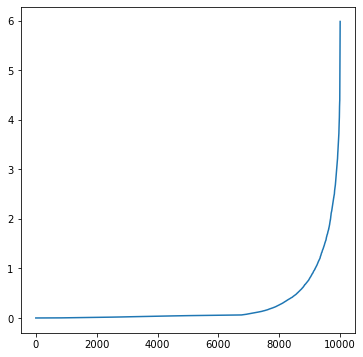

In [49]:
plt.plot(jnp.sort((cord_distance - jnp.median(cord_distance))**2))

### Misc

In [43]:
file1 = "/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem1v/rec_iter_146.mrc"
nx0 = 320
pixel_size = 1.31

vol1 = mrcfile.open(file1).data

vol1_f, _, _ = volume_fourier(vol1, pixel_size)

In [44]:
grid = [1, vol1_f.shape[0]]
vol_fc, _ = rescale_larger_grid(vol1_f, grid, 320)
vol_rc = np.real(np.fft.fftshift(np.fft.ifftn(vol_fc)))


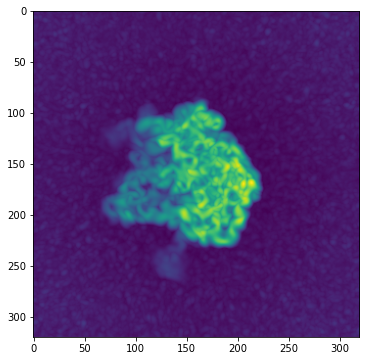

In [45]:
mip_z(vol_rc)

In [46]:
with mrcfile.new(f"/gpfs/gibbs/pi/lederman/bt387/exp_data/vol2_test.mrc", overwrite=True) as mrc:
    mrc.set_data(vol_rc.astype(np.float32))